https://www.kaggle.com/dasolmar/xgb-with-whq-jaccard/code/code

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
import operator
from sklearn.cross_validation import train_test_split
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig

RS = 12357
ROUNDS = 700
x_train_size = (526835, 6)
x_test_size = (2345796, 3)

print("Started")
np.random.seed(RS)
input_folder = './input/'

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


Started


In [14]:
df_train = pd.read_csv(input_folder + 'train.csv')
#df_test  = pd.read_csv(input_folder + 'test.csv')

#print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))

In [ ]:
from collections import Counter

counter = Counter()

def count_duplicates(row):
    counter[row['question1']] += 1
    counter[row['question2']] += 1
    
df_train.apply(count_duplicates, axis=1, raw=True)
df_test.apply(count_duplicates, axis=1, raw=True)

train_q1_freq = df_train['question1'].map(counter)
train_q2_freq = df_train['question2'].map(counter)

test_q1_freq = df_test['question1'].map(counter)
test_q2_freq = df_test['question2'].map(counter)

In [ ]:
train_q1_freq = df_train['question1'].map(counter)
train_q2_freq = df_train['question2'].map(counter)

test_q1_freq = df_test['question1'].map(counter)
test_q2_freq = df_test['question2'].map(counter)

In [ ]:
stops = set(stopwords.words("english"))

def create_feature_map(features):
	outfile = open('xgb.fmap', 'w')
	i = 0
	for feat in features:
		outfile.write('{0}\t{1}\tq\n'.format(i, feat))
		i = i + 1
	outfile.close()

def add_word_count(x, df, word):
	x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
	x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
	x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [ ]:
# build question intersection map

from collections import defaultdict

q_dict = defaultdict(set)

def build_intersects(row):
    q_dict[row['question1']].add(row['question2'])
    q_dict[row['question2']].add(row['question1'])
    
def count_intersect(row):
    return(len(q_dict[row['question1']].intersection(q_dict[row['question2']])))

def count_intersect_l2(row):
    set1 = set(q1 for q in q_dict[row['question1']] for q1 in q_dict[q])
    set2 = set(q2 for q in q_dict[row['question2']] for q2 in q_dict[q])
    return(len(set1.intersection(set2)))

df_train.apply(build_intersects, axis=1, raw=True)
#df_test.apply(build_intersects, axis=1, raw=True)

In [ ]:
import pickle

#pickle.dump(q_dict, open('./datasets/q_intersect_dict.pkl', 'wb'))
q_dict = pickle.load( open('./datasets/q_intersect_dict.pkl', 'rb') )

In [ ]:
#train_intersects = df_train.apply(count_intersect, axis=1, raw=True)
#test_intersects = df_test.apply(count_intersect, axis=1, raw=True)

#train_intersects.to_csv('./datasets/train_intersects.csv', index=False)
#test_intersects.to_csv('./datasets/test_intersects.csv', index=False)

train_intersects = pd.DataFrame.from_csv('./datasets/train_intersects.csv', header = -1)
test_intersects = pd.DataFrame.from_csv('./datasets/test_intersects.csv', header = -1)

In [ ]:
train_intersects_l2 = df_train.apply(count_intersect_l2, axis=1, raw=True)
#test_intersects_i2 = df_test.apply(count_intersect_l2, axis=1, raw=True)

#train_intersects.to_csv('./datasets/train_intersects.csv', index=False)
#test_intersects.to_csv('./datasets/test_intersects.csv', index=False)

#train_intersects = pd.DataFrame.from_csv('./datasets/train_intersects.csv', header = -1)
#test_intersects = pd.DataFrame.from_csv('./datasets/test_intersects.csv', header = -1)

In [ ]:
#train_intersects.shape
#train_intersects_l2 = train_intersects_i2
train_intersects_l2.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

temp = train_intersects.value_counts()
sns.barplot(temp.index[:20], temp.values[:20])

In [ ]:
stops = set(stopwords.words("english"))

def count_interset_meta(row):
    q1_set =  set([w for q in q_dict[row['question1']] for w in str(q).lower().split() if w not in stops])
    if len(q1_set) == 0:
        return '0:0:0:0:0:0:0:0'
        
    q2_set =  set([w for q in q_dict[row['question2']] for w in str(q).lower().split() if w not in stops])
    if len(q2_set) == 0:
        return '0:0:0:0:0:0:0:0'    
    
    shared_words = q1_set.intersection(q2_set)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1_set]
    q2_weights = [weights.get(w, 0) for w in q2_set]
    total_weights = q1_weights + q1_weights    
    
    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1_set) + len(q2_set) - len(shared_words)) #share ratio

    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    
    return '{}:{}:{}:{}'.format(R1, R2, len(shared_words), Rcosine) 

In [ ]:
#df_train_share_meta = df_train.apply(count_interset_meta, axis=1, raw=True)
#df_test_share_meta = df_test.apply(count_interset_meta, axis=1, raw=True)

#df_train_share_meta.to_csv('./datasets/df_train_share_meta_str.csv', index=False)
#df_test_share_meta.to_csv('./datasets/df_test_share_meta_str.csv', index=False)

df_train_share_meta = pd.DataFrame.from_csv('./datasets/df_train_share_meta_str.csv', header = -1)
df_test_share_meta = pd.DataFrame.from_csv('./datasets/df_test_share_meta_str.csv', header = -1)

In [ ]:
df_train_share_meta.shape

In [ ]:
#train_intersects_l2.to_csv('./datasets/train_intersects_l2.csv')
#test_intersects_l2.to_csv('./datasets/test_intersects_l2.csv')

train_intersects_l2 = pd.DataFrame.from_csv('./datasets/train_intersects_l2.csv', header = -1)
test_intersects_l2 = pd.DataFrame.from_csv('./datasets/test_intersects_l2.csv', header = -1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

temp = train_intersects_l2.value_counts()
sns.barplot(temp.index[:20], temp.values[:20])

In [ ]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
	return 0 if count < min_count else 1 / (count + eps)

def word_shares(row):
	q1_list = str(row['question1']).lower().split()
	q1 = set(q1_list)
	q1words = q1.difference(stops)
	if len(q1words) == 0:
		return '0:0:0:0:0:0:0:0'
        
	q2_list = str(row['question2']).lower().split()
	q2 = set(q2_list)
	q2words = q2.difference(stops)
	if len(q2words) == 0:
		return '0:0:0:0:0:0:0:0'

	words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

	q1stops = q1.intersection(stops)
	q2stops = q2.intersection(stops)

	q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
	q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

	shared_2gram = q1_2gram.intersection(q2_2gram)

	shared_words = q1words.intersection(q2words)
	shared_weights = [weights.get(w, 0) for w in shared_words]
	q1_weights = [weights.get(w, 0) for w in q1words]
	q2_weights = [weights.get(w, 0) for w in q2words]
	total_weights = q1_weights + q1_weights
		
	R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
	R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
	R31 = len(q1stops) / len(q1words) #stops in q1
	R32 = len(q2stops) / len(q2words) #stops in q2
	Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
	Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
	if len(q1_2gram) + len(q2_2gram) == 0:
		R2gram = 0
	else:
		R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
	return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)


In [ ]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [ ]:
#df = pd.concat([df_train, df_test])
#df['word_shares'] = df.apply(word_shares, axis=1, raw=True)
df = pd.read_csv('./datasets/why_jaccard_features.csv')
#df.to_csv('./datasets/why_jaccard_features.csv', index=False)

In [ ]:
df_train.shape #526835
df_test.shape #2345796

# df_train.shape[0] + df_test.shape[0] # 2,872,631

In [ ]:
def main():
    print("Features processing, be patient...")
    
    x = pd.DataFrame()

    print('word match')
    x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
    x['word_match_2root'] = np.sqrt(x['word_match'])
    x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
    x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

    print('stops1 ratio')
    x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
    x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
    x['shared_2gram']     = df['word_shares'].apply(lambda x: float(x.split(':')[5]))
    x['cosine']           = df['word_shares'].apply(lambda x: float(x.split(':')[6]))
    x['words_hamming']    = df['word_shares'].apply(lambda x: float(x.split(':')[7]))
    x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

    print('lengths')
    x['len_q1'] = df['question1'].apply(lambda x: len(str(x)))
    x['len_q2'] = df['question2'].apply(lambda x: len(str(x)))
    x['diff_len'] = x['len_q1'] - x['len_q2']

    print('cap counts')
    x['caps_count_q1'] = df['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
    x['caps_count_q2'] = df['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
    x['diff_caps'] = x['caps_count_q1'] - x['caps_count_q2']

    print('len chart')
    x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
    x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
    x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

    print('len word')
    x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
    x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
    x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

    print('avg word len')
    x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
    x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
    x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']
    
    print('exact same')
    x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
    x['duplicated'] = df.duplicated(['question1','question2']).astype(int)
    add_word_count(x, df,'how')
    add_word_count(x, df,'what')
    add_word_count(x, df,'which')
    add_word_count(x, df,'who')
    add_word_count(x, df,'where')
    add_word_count(x, df,'when')
    add_word_count(x, df,'why')
    print('features done...')
    
    print(x.columns)
    #print(x.describe())

    print("Saving processed list...")
    x.to_csv('./datasets/why_jaccard_features_processed.csv', index=False)
    
    feature_names = list(x.columns.values)
    create_feature_map(feature_names)
    print("Features: {}".format(feature_names))
    
    #x_train = x[:df_train.shape[0]]
    #x_test  = x[df_train.shape[0]:]
    #y_train = df_train['is_duplicate'].values
    #del x, df_train
    #return x_train, x_test, y_train

In [ ]:
main()
print("Done.")

In [ ]:
df.shape

In [ ]:
#df = pd.read_csv('./datasets/why_jaccard_features_processed.csv', header=0)
x = df

x['q1_freq'] = train_q1_freq.tolist() + test_q1_freq.tolist()
x['q2_freq'] = train_q2_freq.tolist() + test_q2_freq.tolist()

x_train = df[:x_train_size[0]]
x_test  = df[x_train_size[0]:]
y_train = df_train['is_duplicate'].values
#x.shape

In [ ]:
feature_names = list(x.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(feature_names))

In [ ]:
#x_test[x_test['q1_freq'].isnull()].head()
#x_test['q1_freq'].tail()
#x_train['q1_freq'].isnull().sum()

In [ ]:
x_train.shape

In [ ]:
x_train.to_csv('./datasets/why_jaccard_x_train.csv', index=False)
x_test.to_csv('./datasets/why_jaccard_x_test.csv', index=False)

In [ ]:
x_train = pd.read_csv('./datasets/why_jaccard_x_train.csv', index=False)
x_test = pd.read_csv('./datasets/why_jaccard_x_test.csv', index=False)
y_train = df_train['is_duplicate'].values

In [ ]:
x_train.drop('Unnamed: 0', axis=1, inplace=True)
x_test.drop('Unnamed: 0', axis=1, inplace=True)
x_train.head()

In [ ]:
#x_train = x_train.reset_index()

x_train['q_intersect'] = train_intersects[1].tolist()
x_test['q_intersect'] = test_intersects[1].tolist()

print(x_test.shape, test_intersects.shape)
print(x_train.shape, train_intersects.shape)

#x_train.drop('index', axis=1, inplace=True)
#x_train.head()
#train_intersects[1].shape

In [ ]:
train_intersects_l2 = train_intersects_l2.reset_index()
test_intersects_l2 = test_intersects_l2.reset_index()


x_train['q_intersect_l2'] = train_intersects_l2[0]
x_test['q_intersect_l2'] = test_intersects_l2[0]
#train_intersects_l2.shape
#train_intersects_l2
#x_train['q_intersect_l2']

x_train.head()

In [ ]:
x_train.to_csv('./datasets/why_jaccard_x_intersect_train.csv', index=False)
x_test.to_csv('./datasets/why_jaccard_x_intersect_test.csv', index=False)

In [ ]:
x_train = pd.DataFrame.from_csv('./datasets/why_jaccard_x_intersect_train.csv', index_col=-1)
x_test = pd.DataFrame.from_csv('./datasets/why_jaccard_x_intersect_test.csv', index_col=-1)
x_train = x_train.reset_index()
x_test = x_test.reset_index()
y_train = df_train['is_duplicate'].values

In [ ]:
x_train.head()
#df_train_share_meta.shape
#x_train = x_train.reset_index()
#x_train = x_train.drop('index')
#x_train.drop('index', axis=1, inplace=True)

#x_train['q_intersect_tfidf'] = df_train_share_meta.apply(lambda x: float(x.split(':')[0]))
#col = df_train_share_meta.apply(lambda x: float(x.split(':')[0]))
#col = col.reset_index()
#col.drop('level_0', axis=1, inplace=True)
#x_train['q_intersect_tfidf'] = col

In [ ]:
df_train_share_meta = df_train_share_meta.reset_index()
df_test_share_meta = df_test_share_meta.reset_index()

x_train['q_intersect_tfidf'] = df_train_share_meta[0].apply(lambda x: float(x.split(':')[0])).reset_index()[0]
x_train['q_intersect_shared_ratio'] = df_train_share_meta[0].apply(lambda x: float(x.split(':')[1])).reset_index()[0]
x_train['q_intersect_shared_count'] = df_train_share_meta[0].apply(lambda x: float(x.split(':')[2])).reset_index()[0]
x_train['q_intersect_shared_cosine'] = df_train_share_meta[0].apply(lambda x: float(x.split(':')[3])).reset_index()[0]

x_test['q_intersect_tfidf'] = df_test_share_meta[0].apply(lambda x: float(x.split(':')[0])).reset_index()[0]
x_test['q_intersect_shared_ratio'] = df_test_share_meta[0].apply(lambda x: float(x.split(':')[1])).reset_index()[0]
x_test['q_intersect_shared_count'] = df_test_share_meta[0].apply(lambda x: float(x.split(':')[2])).reset_index()[0]
x_test['q_intersect_shared_cosine'] = df_test_share_meta[0].apply(lambda x: float(x.split(':')[3])).reset_index()[0]

In [ ]:
#x_train.to_csv('./datasets/why_jaccard_x_intersect_train_extended.csv')
#x_test.to_csv('./datasets/why_jaccard_x_intersect_test_extended.csv')

x_train = pd.DataFrame.from_csv('./datasets/why_jaccard_x_intersect_train_extended.csv')
y_train = df_train['is_duplicate'].values
#x_test = pd.DataFrame.from_csv('./datasets/why_jaccard_x_intersect_test_extended.csv')

In [ ]:
# load Abhishek features
xb_feats = ['braycurtis_distance', 'canberra_distance', 'cityblock_distance', 'common_words', 'cosine_distance', 'euclidean_distance', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio', 'fuzz_qratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'jaccard_distance', 'kur_q1vec', 'minkowski_distance', 'norm_wmd', 'skew_q1vec', 'skew_q2vec', 'wmd']

xb_train = pd.DataFrame.from_csv('./input/Quora/train_features.csv', encoding="ISO-8859-1")
xb_train = xb_train.reset_index()
xb_train = xb_train.loc[:, xb_feats]

In [ ]:
# load Abhishek features
xb_feats = ['braycurtis_distance', 'canberra_distance', 'cityblock_distance', 'common_words', 'cosine_distance', 'euclidean_distance', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio', 'fuzz_qratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'jaccard_distance', 'kur_q1vec', 'minkowski_distance', 'norm_wmd', 'skew_q1vec', 'skew_q2vec', 'wmd']

xb_test = pd.DataFrame.from_csv('./input/Quora/test_features.csv', encoding="ISO-8859-1")
xb_test = xb_test.reset_index()
xb_test = xb_test.loc[:, xb_feats]

In [ ]:
#print(x_train.shape, xb_train.shape)
#x_test.shape
#df_test_share_meta.shape
#df_train_share_meta.apply(lambda x: float(x.split(':')[0])).shape
#x_train[x_train.duplicated()].shape
#x_train[x_train.duplicated()].head()
#df_train_share_meta.head()
#df_train_share_meta.apply(lambda x: str(x).split(':'))
#x_train.loc[:10, ['q_intersect', 'shared_count']]
#xb_train.loc[:10, ['common_words']]

x_train = pd.concat([x_train, xb_train], axis=1)
del xb_train
x_train.shape

In [ ]:
x_test = pd.concat([x_test, xb_test], axis=1)
del xb_test
x_test.shape

In [ ]:
#x_train.to_csv('./datasets/ab_train_2.csv')
#x_test.to_csv('./datasets/ab_test_2.csv')

x_train = pd.DataFrame.from_csv('./datasets/ab_train_2.csv').reset_index(drop=['index'])
#x_test = pd.DataFrame.from_csv('./datasets/ab_test_2.csv').reset_index(drop=['index'])

In [ ]:
x_train_extra = pd.read_csv('./datasets/ab_freq_train.csv')
x_train_extra = x_train_extra.drop('Unnamed: 0', axis=1).reset_index(drop=['index'])
x_train_extra.rename(columns={"word_match": "word_match_sum"}, inplace=True)
x_train_extra.columns.values

#x_test_extra = pd.read_csv('./datasets/ab_freq_test.csv')
#x_test_extra = x_test_extra.drop('Unnamed: 0', axis=1).reset_index(drop=['index'])
#x_test_extra.rename(columns={"word_match": "word_match_sum"}, inplace=True)
#x_test_extra.columns.values

x_train = pd.concat([x_train, x_train_extra], axis=1)
y_train = df_train['is_duplicate'].values
#x_test = pd.concat([x_test, x_test_extra], axis=1)

x_train.to_csv('./datasets/ab_nlp_92_train.csv')
#x_test.to_csv('./datasets/ab_nlp_92_test.csv')

del x_train_extra
del x_test_extra

In [2]:
x_train = pd.DataFrame.from_csv('./datasets/ab_nlp_92_train.csv').reset_index(drop=['index'])
#x_test = pd.DataFrame.from_csv('./datasets/ab_nlp_92_test.csv').reset_index(drop=['index'])
#y_train = df_train['is_duplicate'].values

In [5]:
#x_train_spacy = pd.DataFrame.from_csv('./datasets/x_train_spacy.csv').reset_index(drop=['index'])
x_test_spacy = pd.read_csv('./datasets/x_test_spacy.csv').reset_index(drop=['index'])

In [6]:
#x_train_kcores = pd.read_csv('./datasets/max_kcores_train.csv').reset_index(drop=['index'])
x_test_kcores = pd.read_csv('./datasets/max_kcores_test.csv').reset_index(drop=['index', 'Unnamed: 0'])

#x_train = pd.concat([x_train, x_train_kcores, x_train_spacy], axis=1)
x_test = pd.concat([x_test, x_test_kcores, x_test_spacy], axis=1)
x_test.drop('Unnamed: 0', inplace=True, axis=1)
del x_test_spacy, x_test_kcores
x_test.drop('Unnamed: 0', inplace=True, axis=1)

#x_train.tail()
#x_train_com.columns.values
#x_train.columns.values
#x_train_kcores.tail()
#x_train.shape

x_train.shape
#x_train_spacy.shape

NameError: name 'x_train' is not defined

In [4]:
x_train.columns.values

array(['word_match', 'word_match_2root', 'tfidf_word_match',
       'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram',
       'cosine', 'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2',
       'diff_len', 'caps_count_q1', 'caps_count_q2', 'diff_caps',
       'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1',
       'len_word_q2', 'diff_len_word', 'avg_world_len1', 'avg_world_len2',
       'diff_avg_word', 'exactly_same', 'duplicated', 'q1_how', 'q2_how',
       'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which',
       'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both',
       'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when',
       'when_both', 'q1_why', 'q2_why', 'why_both', 'q1_freq', 'q2_freq',
       'q_intersect', 'q_intersect_l2', 'q_intersect_tfidf',
       'q_intersect_shared_ratio', 'q_intersect_shared_count',
       'q_intersect_shared_cosine', 'braycurtis_distance',
       'canberra_distance', 'cityblock_distance', 'common_w

-----------------

-----------------
## Training



In [ ]:
if 1: # Now we oversample the negative class - on your own risk of overfitting!
	pos_train = x_train[y_train == 1]
	neg_train = x_train[y_train == 0]

	print("Oversampling started for proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))
	p = 0.165
	scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
	while scale > 1:
	M	neg_train = pd.concat([neg_train, neg_train])
		scale -=1
	neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
	print("Oversampling done, new proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))

	x_train = pd.concat([pos_train, neg_train])
	y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
	del pos_train, neg_train

In [2]:
def train_xgb(x_train, x_val, y_train, y_val, params):
	print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))

	xg_train = xgb.DMatrix(x_train, label=y_train)
	xg_val = xgb.DMatrix(x_val, label=y_val)

	watchlist  = [(xg_train,'train'), (xg_val,'eval')]
	return xgb.train(params, xg_train, ROUNDS, watchlist), xg_train, xg_val

def predict_xgb(bst, x_test):
	return bst.predict(xgb.DMatrix(x_test))

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.05, random_state=RS)

print("Train ratio: {}, Val ratio: {}".format(sum(y_train)/len(y_train), sum(y_valid)/len(y_valid)))

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['silent'] = 1
params['seed'] = RS

print("Training data: X_train: {}, Y_train: {}".format(x_train.shape, len(y_train)))
bst, xg_train, xg_val = train_xgb(x_train, x_valid, y_train, y_valid, params)

In [ ]:
p_train = bst.predict(xg_train)
p_val = bst.predict(xg_val)

val_prec = sum((p_val > 0.5) == y_valid)/len(y_valid)
train_prec = sum((p_train > 0.5) == y_train)/len(p_train)

print("Training accuracy: {}, Validation accuracy: {}".format(train_prec, val_prec))

In [3]:
import pickle

#pickle.dump(bst, open('./models/models_spacy_sim_' + str(ROUNDS) + '.pkl', 'wb'))
bst = pickle.load( open('./models/models_spacy_sim_' + str(ROUNDS) + '.pkl', 'rb') )

In [15]:
print("predicting...")
preds = predict_xgb(bst, x_test)

print("Writing output...")
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = preds
sub.to_csv("xgb_seed{}_ab_nlp_n{}.csv".format(RS, ROUNDS), index=False)

predicting...
Writing output...


Features importances...
[('word_match_2root', 1), ('where_both', 6), ('when_both', 10), ('q2_where', 11), ('q1_when', 15), ('who_both', 16), ('euclidean_distance', 17), ('q1_who', 17), ('which_both', 19), ('q2_who', 20), ('q1_where', 21), ('q2_when', 22), ('q2_which', 28), ('what_both', 34), ('why_both', 35), ('how_both', 36), ('diff_len_word', 41), ('q2_why', 44), ('wc_diff', 47), ('q1_how', 49), ('q1_why', 50), ('q2_how', 53), ('wc_diff_unique', 53), ('q1_which', 55), ('q2_what', 63), ('wc_diff_unq_stop', 65), ('diff_len_char', 78), ('shared_count', 78), ('same_start', 81), ('q1_what', 87), ('diff_len', 97), ('common_words', 110), ('len_word_q2', 134), ('cityblock_distance', 143), ('wc_ratio', 146), ('len_word_q1', 148), ('wc_ratio_unique_stop', 149), ('wc_ratio_unique', 155), ('caps_count_q2', 158), ('char_diff', 166), ('caps_count_q1', 171), ('len_char_q2', 176), ('minkowski_distance', 182), ('fuzz_WRatio', 184), ('total_unique_words', 188), ('len_q1', 189), ('len_q2', 193), ('char

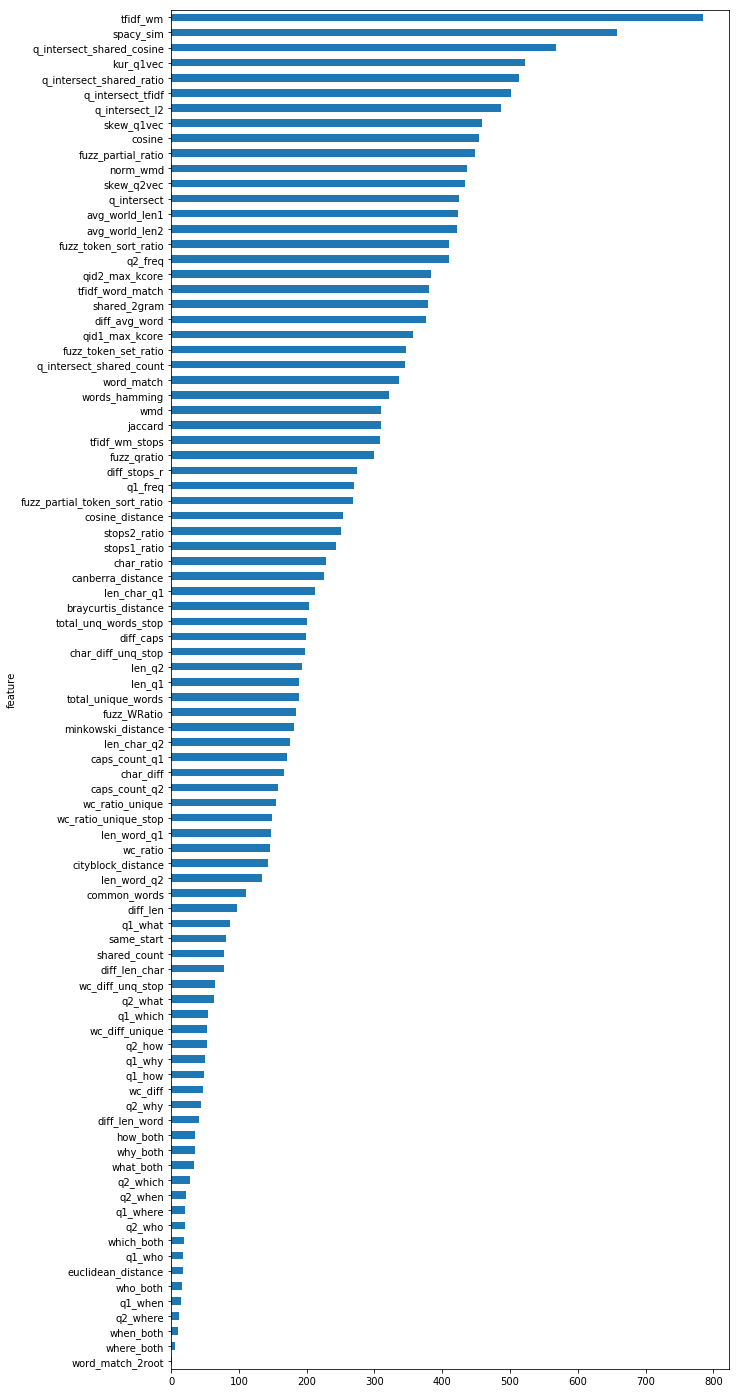

In [18]:
%matplotlib inline

print("Features importances...")
importance = bst.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])
print(importance)

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')

### Logloss

#### Iteration 200

* With freq ~ XGB depth 9 - train-error:0.099994	eval-error:0.109187 | Training accuracy: 0.9000060058857681, Validation accuracy: 0.9108810198753984 | **0.22 on LB**

#### Iteration 315
 
* With freq - [314]	train-logloss:0.239994	eval-logloss:0.246721 **(0.21956 on LB)**
* Without freq - [314]	train-logloss:0.312187	eval-logloss:0.319391

#### iteration 350

* With intersect l2 - train-logloss:0.18714	eval-logloss:0.194974 

* With intersect - [349]	train-logloss:0.187006	eval-logloss:0.194715 | Training accuracy: 0.921968923517218, Validation accuracy: 0.9198718770019219 **(0.17036 on LB)**
* With freq - [349]	train-logloss:0.238551	eval-logloss:0.245807 **(0.21543 on LB)**

#### iteration 380

* With freq - [379]	train-logloss:0.237033	eval-logloss:0.244844 **(0.21524 on LB)**
* With 0.05 split - [379]	train-logloss:0.238077	eval-logloss:0.246341
* [379]	train-logloss:0.235721	eval-logloss:0.246734 | Training accuracy: 0.895017116774439, Validation accuracy: 0.9108810198753984

#### iteration 400

* jaccard features + freq - [399]	train-error:0.086034	eval-error:0.102852 | Training accuracy: 0.9139656863726452, Validation accuracy: 0.9108810198753984

#### iteration 450
* With level 2 intersection counts - Training accuracy: 0.9238988969075919, Validation accuracy: 0.9213581037796285
* Training accuracy: 0.9232420855581076, Validation accuracy: 0.9205637411915438 **LB 0.16956**
* [449]	train-error:0.086919	eval-error:0.101089 | Training accuracy: 0.9130810656258387, Validation accuracy: 0.8989109545163357 **LB: 0.22403**

#### iteration 550

* With level 2 intersection counts - [549]	train-logloss:0.180859	eval-logloss:0.191727 | Training accuracy: 0.9247040640033664, Validation accuracy: 0.9213837283792441 **(0.16748 on LB)**

#### iteration 600
* [599]	**Abhishek + my data + extended 16 + kcores** - train-logloss:0.153991	eval-logloss:0.167997 | Training accuracy: 0.9360249561339032, Validation accuracy: 0.9307879564381807 **LB 0.15009**


#### iteration 700

* (5/31) - **Abhishek + my data + extended 16 + kcores + spacy similarity** [699]	train-logloss:0.149663	eval-logloss:0.1654 - Training accuracy: 0.9380385482176405, Validation accuracy: 0.9318129404228059
* (5/28) - **Abhishek + my data + extended 16 + kcores** - [699]	train-logloss:0.150528	eval-logloss:0.166323 | Training accuracy: 0.9375840401585518, Validation accuracy: 0.9317104420243434 - **LB 0.15004**


#### iteration 800

* (5/28) - **Abhishek + my data + extended 16 + kcores** - **LB 0.15013**
* (5/28) - **Abhishek + my data + extended 16** - [799]	train-logloss:0.151459	eval-logloss:0.170253 | Training accuracy: 0.9373749934251431, Validation accuracy: 0.9306085842408712
* (5/28) - **Abhishek + my data** - [799]	train-logloss:0.154675	eval-logloss:0.172463 | Training accuracy: 0.936066765480585, Validation accuracy: 0.9293529788597054 **(LB 0.15753)**
* (05/27) - Without enriched data - [799]	train-logloss:0.17021	eval-logloss:0.185971
* (05/26) - with enriched data - [799]	train-logloss:0.169883	eval-logloss:0.183347 | Training accuracy: 0.9253261150733528, Validation accuracy: 0.9181795386158476
* With intersect shared features - Training accuracy: 0.9291331573744269, Validation accuracy: 0.9237155669442665 **(LB 0.16562)**
* With intersect l2 - [799]	train-logloss:0.174332	eval-logloss:0.188918 | Training accuracy: 0.9275996984332284, Validation accuracy: 0.9224855861627163 **(0.16743 on LB)**
* With freq - [799]	train-logloss:0.223248	eval-logloss:0.237988 **(0.21861 on LB)**
In [13]:

#### interation 1000
* **Abhishek + my data + extended 16 + kcores** - [999]	train-logloss:0.14182	eval-logloss:0.162557 | Training accuracy: 0.941806784173409, Validation accuracy: 0.9340422805893658 **LB 0.15059**

#### Iteration 1200
* (05/28) - **Abhishek + my data** - [1156]	train-logloss:0.14481	eval-logloss:0.168295 | Training accuracy: 0.9414898423517892, Validation accuracy: 0.9321204356181935 | ** LB 0.15814 **
* (05/26) -  with enriched data - [1199]	train-logloss:0.160763	eval-logloss:0.179314 | 0.9302726116129169, Validation accuracy: 0.9206619859578736


#### iteration 1500
* With intersect shared features [1499]	train-logloss:0.155224	eval-logloss:0.180205 | Training accuracy: 0.9359534756379634, Validation accuracy: 0.9265855221012171 **(0.16684)**

## Features

#### TODO

* word share
* tfidf_wm_stops
* wc_ratio
* wc_diff_unique
* wc_ratio_unique
* common_words
* total_unique_words
* total_unq_words_stop
* wc_diff_unique_stop
* wc_ratio_unique_stop
* same_start_word
* char_ratio
* char_diff_unique_stop
* tfidf_word_match_share
* tfidf_word_match_share_stops

* ['tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff', 'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique', 'wc_diff_unq_stop', 'wc_ratio_unique_stop', 'same_start', 'char_diff', 'char_diff_unq_stop', 'total_unique_words', 'total_unq_words_stop', 'char_ratio']

#### common

{'diff_len',
 'len_char_q1',
 'len_char_q2',
 'len_q1',
 'len_q2',
 'len_word_q1',
 'len_word_q2'
 }

#### From Abhishek's features

{'braycurtis_distance',
 'canberra_distance',
 'cityblock_distance',
 'common_words',
 'cosine_distance',
 'euclidean_distance',
 'fuzz_WRatio',
 'fuzz_partial_ratio',
 'fuzz_partial_token_set_ratio',
 'fuzz_partial_token_sort_ratio',
 'fuzz_qratio',
 'fuzz_token_set_ratio',
 'fuzz_token_sort_ratio',
 'jaccard_distance',
 'kur_q1vec',
 'minkowski_distance',
 'norm_wmd',
 'skew_q1vec',
 'skew_q2vec',
 'wmd'}
 
 
 #### My features
 ['word_match',
 'word_match_2root',
 'tfidf_word_match',
 'shared_count',
 'stops1_ratio',
 'stops2_ratio',
 'shared_2gram',
 'cosine',
 'words_hamming',
 'diff_stops_r',
 'len_q1',
 'len_q2',
 'diff_len',
 'caps_count_q1',
 'caps_count_q2',
 'diff_caps',
 'len_char_q1',
 'len_char_q2',
 'diff_len_char',
 'len_word_q1',
 'len_word_q2',
 'diff_len_word',
 'avg_world_len1',
 'avg_world_len2',
 'diff_avg_word',
 'exactly_same',
 'duplicated',
 'q1_how',
 'q2_how',
 'how_both',
 'q1_what',
 'q2_what',
 'what_both',
 'q1_which',
 'q2_which',
 'which_both',
 'q1_who',
 'q2_who',
 'who_both',
 'q1_where',
 'q2_where',
 'where_both',
 'q1_when',
 'q2_when',
 'when_both',
 'q1_why',
 'q2_why',
 'why_both',
 'q1_freq',
 'q2_freq',
 'q_intersect',
 'q_intersect_l2',
 'q_intersect_tfidf',
 'q_intersect_shared_ratio',
 'q_intersect_shared_count',
 'q_intersect_shared_cosine']

## Features

#### TODO

* word share
* tfidf_wm_stops
* wc_ratio
* wc_diff_unique
* wc_ratio_unique
* common_words
* total_unique_words
* total_unq_words_stop
* wc_diff_unique_stop
* wc_ratio_unique_stop
* same_start_word
* char_ratio
* char_diff_unique_stop
* tfidf_word_match_share
* tfidf_word_match_share_stops

* ['tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff', 'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique', 'wc_diff_unq_stop', 'wc_ratio_unique_stop', 'same_start', 'char_diff', 'char_diff_unq_stop', 'total_unique_words', 'total_unq_words_stop', 'char_ratio']

#### common

{'diff_len',
 'len_char_q1',
 'len_char_q2',
 'len_q1',
 'len_q2',
 'len_word_q1',
 'len_word_q2'
 }

#### From Abhishek's features

{'braycurtis_distance',
 'canberra_distance',
 'cityblock_distance',
 'common_words',
 'cosine_distance',
 'euclidean_distance',
 'fuzz_WRatio',
 'fuzz_partial_ratio',
 'fuzz_partial_token_set_ratio',
 'fuzz_partial_token_sort_ratio',
 'fuzz_qratio',
 'fuzz_token_set_ratio',
 'fuzz_token_sort_ratio',
 'jaccard_distance',
 'kur_q1vec',
 'minkowski_distance',
 'norm_wmd',
 'skew_q1vec',
 'skew_q2vec',
 'wmd'}
 
 
 #### My features
 ['word_match',
 'word_match_2root',
 'tfidf_word_match',
 'shared_count',
 'stops1_ratio',
 'stops2_ratio',
 'shared_2gram',
 'cosine',
 'words_hamming',
 'diff_stops_r',
 'len_q1',
 'len_q2',
 'diff_len',
 'caps_count_q1',
 'caps_count_q2',
 'diff_caps',
 'len_char_q1',
 'len_char_q2',
 'diff_len_char',
 'len_word_q1',
 'len_word_q2',
 'diff_len_word',
 'avg_world_len1',
 'avg_world_len2',
 'diff_avg_word',
 'exactly_same',
 'duplicated',
 'q1_how',
 'q2_how',
 'how_both',
 'q1_what',
 'q2_what',
 'what_both',
 'q1_which',
 'q2_which',
 'which_both',
 'q1_who',
 'q2_who',
 'who_both',
 'q1_where',
 'q2_where',
 'where_both',
 'q1_when',
 'q2_when',
 'when_both',
 'q1_why',
 'q2_why',
 'why_both',
 'q1_freq',
 'q2_freq',
 'q_intersect',
 'q_intersect_l2',
 'q_intersect_tfidf',
 'q_intersect_shared_ratio',
 'q_intersect_shared_count',
 'q_intersect_shared_cosine']

2/6 - 180